In [199]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from collections import Counter, defaultdict
import plotly.graph_objects as go
import numpy as np
import powerlaw
from netwulf import visualize
import netwulf as nw
import seaborn as sns

In [358]:
R = pd.read_pickle("edgelist_reindexed.pkl")

In [ ]:
R["link"] = R.apply(lambda r: "same name as" if (r._type == "same_name_as") else r.link, axis = 1)
R["link"] = R.apply(lambda r: "registered address" if (r._type == "registered_address") else r.link, axis = 1)

In [359]:
R._start = R._start.astype(np.int64)
R._end   = R._end.astype(np.int64)
hit_list = ["RUS", "USA", "CHN", 'HKG', "CHE"]
R1 = R[R._start_country.isin(hit_list) & (R._start_type == "Officers") & (R._end_type == "Entity")]
B = R1._start.unique()
E = R1._end.unique()
R2 = R[(R._start_type == "Intermediaries") & R._end.isin(E)]
I = R2._start.unique()

In [360]:
R3 = R[(R._start.isin(E)) & (R._end_type == "Address")]
ent2add = dict(zip(R3._start.values, R3._end_country.values))

In [361]:
R_sub = pd.concat((R1,R2))
G = nx.Graph()
G.add_edges_from(R_sub[["_start", "_end"]].values )

In [367]:
%%time
# Connect intermediaries with clients
new_EL = []
for n in G.nodes():
    if id2type[n] == "Entity":
        nei = list( G.neighbors(n) )
        bens = [m for m in nei if id2type[m] == "Officers"]
        ints = [m for m in nei if id2type[m] == "Intermediaries"]
        if (len(bens) > 1) and (len(ints) > 1):
            new_EL += list( product(bens,ints) )

ego = []
neis = []
for n in I:
    nei = G.neighbors(n)
    nei = [m for m in nei if id2type[m] == "Entity"]
    for m in nei:
        try:
            ego.append(n)
            neis.append(ent2add[m])
        except:
            pass

Wall time: 174 ms


In [345]:
max_index = max(G.nodes())
factors_cc, unique_cc = pd.factorize(neis)
factors_cc = factors_cc + max_index + 1
new_EL += list(zip(ego,factors_cc))

In [ ]:
hit_list = ["RUS", "USA", "CHN", 'HKG', "CHE"]

In [406]:
id2type  = dict(zip(R_sub._start.values, R_sub._start_type.values))
id2cntry = dict(zip(R_sub._start.values, R_sub._start_country.values))
id2type.update( dict(zip(R_sub._end.values, R_sub._end_type.values)))
id2type.update( dict(zip(R_sub._end.values, R_sub._end_type.values)))
hit_list = ["RUS", "USA", "CHN", 'HKG', "CHE"]
cntry2col = dict(zip(hit_list, ["red", "royalblue", "purple", "mediumseagreen", "orange"]))

In [407]:
def label_color(n):
    if n in list(range(max_index+1, max_index+len(unique_cc)+1)):
        return "grey"
    elif id2type[n] == "Intermediaries":
        return "yellow"
    else:
        return cntry2col[id2cntry[n]]

In [400]:
# R_sub = pd.concat((R1,R2,R3))
R_sub = pd.concat((R1,R2))
G1 = nx.Graph()
G1.add_edges_from(R_sub[["_start", "_end"]].values )

In [401]:
new_EL = []
for n in G1.nodes():
    if id2type[n] == "Entity":
        nei = list( G1.neighbors(n) )
        bens = [m for m in nei if id2type[m] == "Officers"]
        ints = [m for m in nei if id2type[m] == "Intermediaries"]
        if (len(bens) >= 1) and (len(ints) >= 1):
            new_EL += list( product(bens,ints) )

In [402]:
H = nx.Graph()
H.add_edges_from(new_EL)

In [409]:
for k, v in H.nodes(data=True):
    try:
        v["group"] = label_color(k)
        v["label"] = "d"
    except:
        print(k)

In [ ]:
hit_list = ["RUS", "USA", "CHN", 'HKG', "CHE"]
cntry2col = dict(zip(hit_list, ["red", "royalblue", "purple", "mediumseagreen", "orange"]))

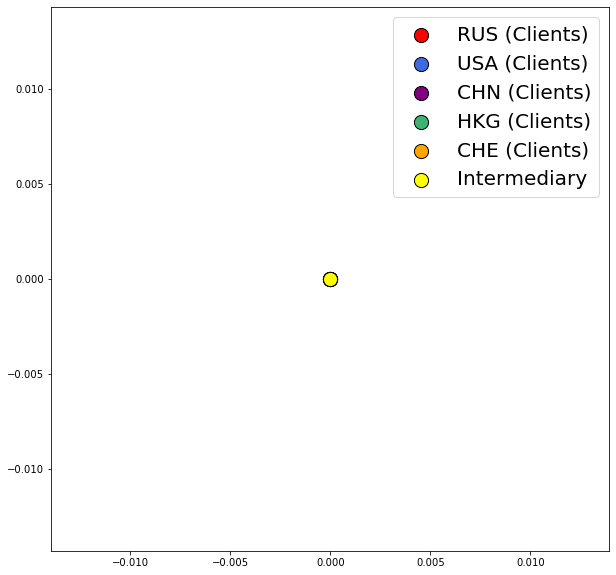

In [414]:
plt.figure(figsize=(10,10))
plt.scatter(0,0, label = "RUS (Clients)",         c = "red",edgecolors='black', s = 200)
plt.scatter(0,0, label = "USA (Clients)",     c = "royalblue",edgecolors='black', s = 200)
plt.scatter(0,0, label = "CHN (Clients)",  c = "purple",edgecolors='black', s = 200)
plt.scatter(0,0, label = "HKG (Clients)", c = "mediumseagreen",edgecolors='black', s = 200)
plt.scatter(0,0, label = "CHE (Clients)",   c = "orange",edgecolors='black', s = 200)
plt.scatter(0,0, label = "Intermediary",   c = "yellow",edgecolors='black', s = 200)
plt.legend(fontsize=20)

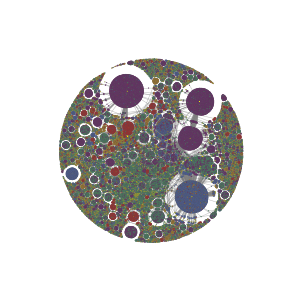

In [410]:
stylized_network, config = visualize(H)

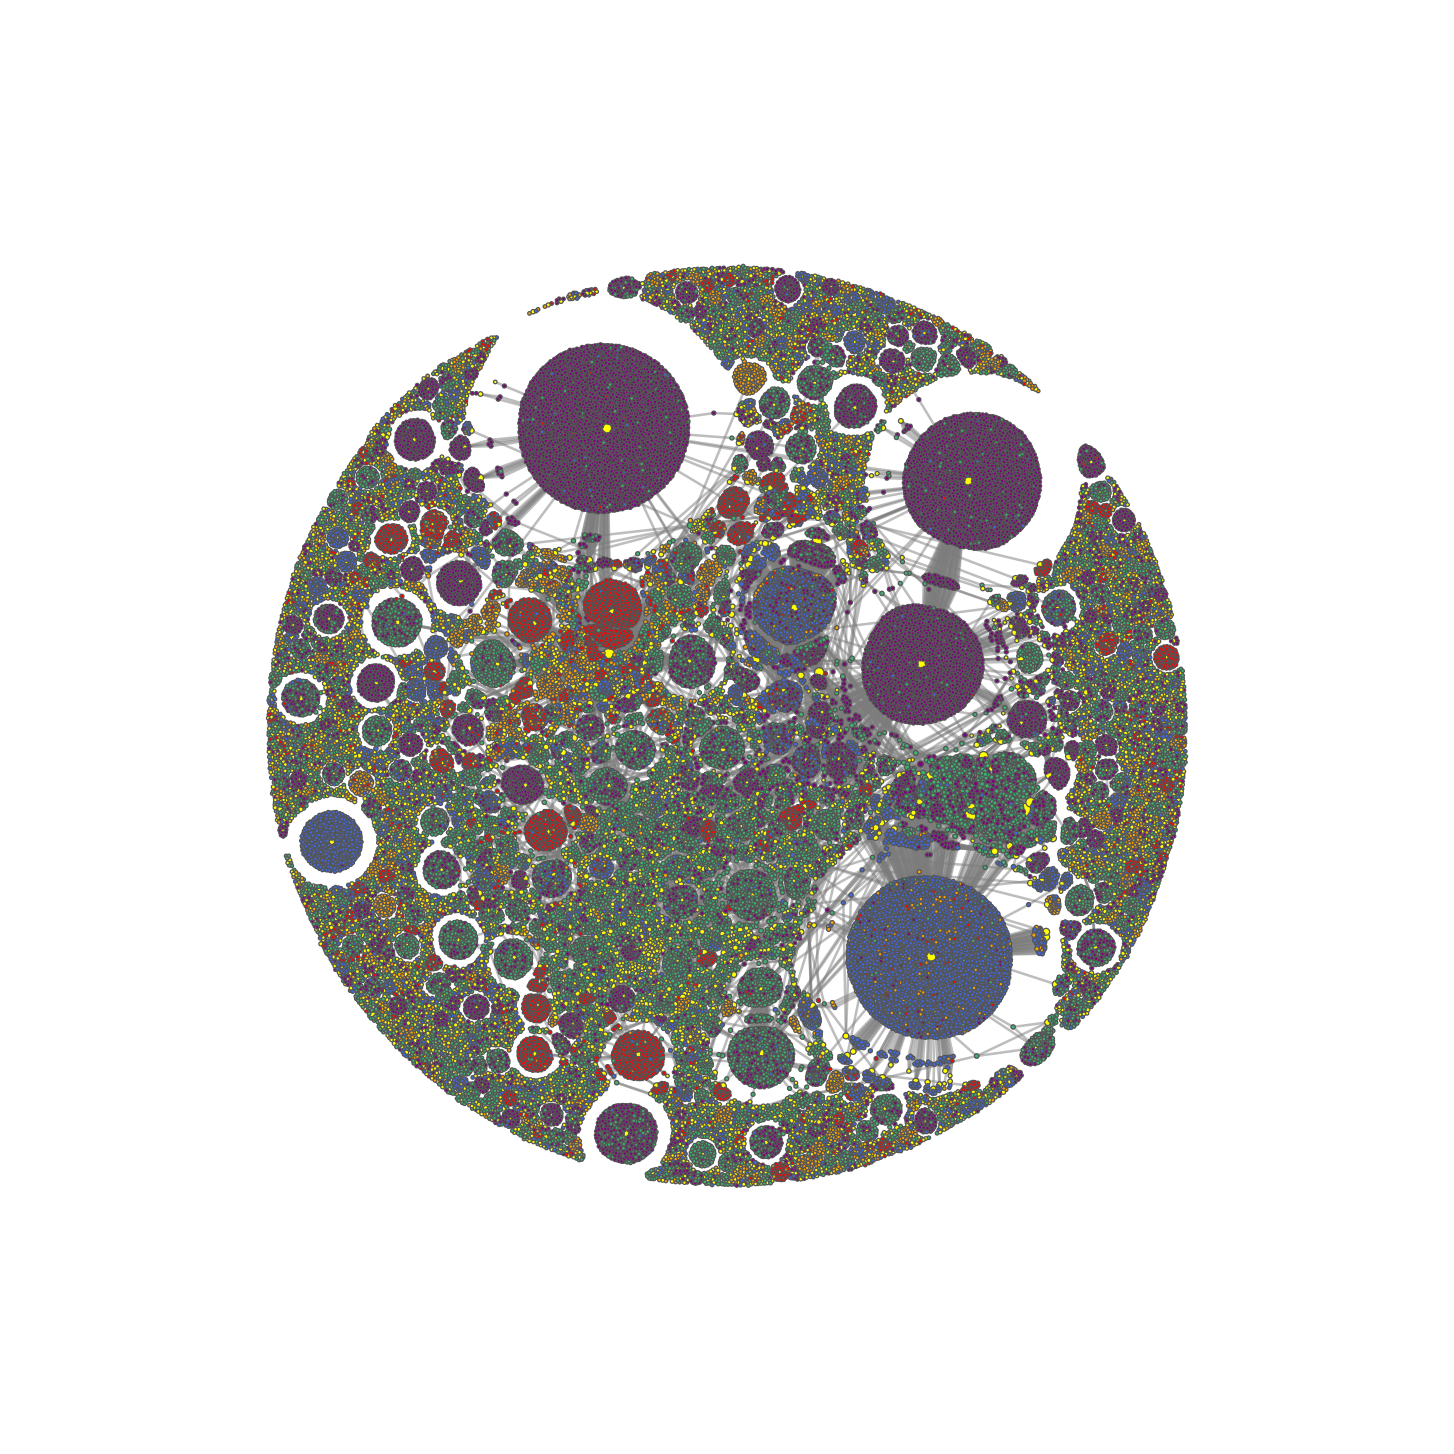

In [412]:
fig, ax = nw.draw_netwulf(stylized_network,figsize=20)
plt.savefig("figures/all_countries.png", bbox_inches = "tight")